# Hierarchical Risk Parity

The key idea of hierarchical risk parity is to use hierarchical clustering on the covariance matrix to be able to group assets with similar correlations together and reduce the number of degrees of freedom by only considering 'similar' assets as substitutes when constructing the portfolio.

## Imports & Settings

In [85]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns
from talib import RSI, BBANDS, MACD, ATR

In [86]:
sns.set_style('whitegrid')
np.random.seed(42)

In [87]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = None

## Load Data

In [88]:
# df = pd.read_csv('../SampleDataSet.csv')
# df['DATE'] = pd.to_datetime(df['DATE'])
# descr = df.describe()
# df = df.groupby(['DATE','RP_ENTITY_ID'], as_index=False).first()
# ###col with 100% NA
# cols_to_drop = descr.columns[descr.loc['count',:]==0]
# ###delete these cols
# df = df.loc[:, ~df.columns.isin(cols_to_drop)]
# # q = 0.9995
# # df = df.loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) 
# #             & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) 
# #             & (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) 
# #             & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]



# nb_date_ceil = 9000
# # nb_date_floor = 1764 #7y track record
# nb_date_floor = 756 #3y track record



# list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)
#                                                 &(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
# list_asset = list(list_asset)

# df_track_perf = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]
# # df_track_perf.describe()

# df_track_perf['T0_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T0_RETURN'].copy()) ##use log return
# df_track_perf['T1_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T1_RETURN'].copy()) ##use log return
# cols_to_drop = ['T0_RETURN', 'T1_RETURN']
# df_track_perf = df_track_perf.loc[:, ~df_track_perf.columns.isin(cols_to_drop)]

In [89]:
df = pd.read_csv('../SampleDataSet.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
###col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
###delete these cols
df = df.loc[:, ~df.columns.isin(cols_to_drop)]
# q = 0.9995
# df = df.loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) 
#             & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) 
#             & (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) 
#             & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]



nb_date_ceil = 15000
nb_date_floor = 756 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

df = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]
# df_track_perf.describe()

df['T0_RETURN_log'] = np.log(1+df.loc[:,'T0_RETURN'].copy()) ##use log return
df['T1_RETURN_log'] = np.log(1+df.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df0 = df.loc[:, ~df.columns.isin(cols_to_drop)].copy()

# df_train_valid_inter = df_track_perf.iloc[ :int(round(len(df_track_perf)*0.85,0)) , :]
# ret = 0.0
# perf_range = (df_train_valid_inter['T1_RETURN_log']>=ret) | (df_train_valid_inter['T1_RETURN_log']<-ret)
# df_train_valid = df_train_valid_inter.loc[ perf_range ] ################# CHANGER LE SPLIT TRAIN VALID !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# df_test = df_track_perf.iloc[int(round(len(df_track_perf)*0.85+30,0)): , :] ### EMBARGO

## Remove assets with few observations

In [90]:
len(list_asset)

256

In [91]:
#daily_returns = daily_returns.dropna(axis=1)
# daily_returns.columns.names = ['Ticker']
# daily_returns.info()

daily_returns = df0.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
# daily_returns = daily_returns.resample('D').sum().dropna(how='all')
daily_returns = daily_returns.loc[daily_returns.index.year >= 2010,:]
daily_returns = daily_returns.dropna(how='all')
daily_returns

RP_ENTITY_ID  00067A  013528  0157B1  034B61  03B8CF  047E26  048590  055018  \
DATE                                                                           
2010-01-04       nan     nan  -0.021   0.009     nan   0.048   0.001     nan   
2010-01-05       nan     nan   0.000     nan     nan   0.052     nan   0.033   
2010-01-06       nan  -0.015  -0.023  -0.038   0.009     nan     nan   0.001   
2010-01-07     0.040  -0.012     nan     nan  -0.005  -0.036  -0.030     nan   
2010-01-08       nan  -0.007     nan  -0.004     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.003   0.001   0.008     nan   0.008  -0.017  -0.036   0.004   
2017-02-14    -0.007   0.000  -0.004  -0.009  -0.000   0.022  -0.019   0.010   
2017-02-15    -0.008  -0.007   0.002   0.002   0.002   0.000   0.006   0.003   
2017-02-16     0.019   0.015   0.004     nan     nan  -0.011   0.000  -0.003   
2017-02-17    -0.022     nan  -0.001     nan     nan     nan  -0.003   0.013   

RP_ENTITY_ID  061366  061856  095294  09DE1F  0A9D0A  0BC29E  0BF4BA  0F0440  \
DATE                                                                           
2010-01-04       nan     nan     nan     nan     nan     nan  -0.023     nan   
2010-01-05       nan     nan     nan     nan     nan  -0.025  -0.000     nan   
2010-01-06       nan     nan     nan     nan     nan  -0.011  -0.026   0.008   
2010-01-07       nan     nan  -0.016     nan     nan  -0.026  -0.003  -0.029   
2010-01-08       nan     nan     nan     nan     nan   0.022  -0.010  -0.016   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.011   0.008  -0.009   0.002   0.006   0.005     nan     nan   
2017-02-14     0.014  -0.005  -0.007  -0.010   0.021   0.008     nan   0.028   
2017-02-15       nan  -0.003  -0.004     nan   0.028  -0.100     nan  -0.000   
2017-02-16    -0.016   0.004   0.011   0.013  -0.019   0.025     nan  -0.029   
2017-02-17       nan  -0.003     nan   0.009     nan   0.002     nan     nan   

RP_ENTITY_ID  0F7B72  12A3A3  12DE76  12E454  131443  13C3E0  143C52  14BA06  \
DATE                                                                           
2010-01-04    -0.014     nan     nan     nan     nan     nan     nan     nan   
2010-01-05    -0.029   0.004  -0.010     nan   0.018     nan     nan     nan   
2010-01-06     0.003  -0.002  -0.011     nan     nan     nan     nan  -0.008   
2010-01-07     0.019     nan  -0.002     nan     nan   0.011     nan     nan   
2010-01-08       nan  -0.002   0.001     nan   0.048  -0.021     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13       nan   0.000   0.011  -0.004   0.012     nan     nan  -0.007   
2017-02-14       nan  -0.003   0.007  -0.005  -0.009  -0.021   0.023   0.012   
2017-02-15       nan   0.001   0.010  -0.008  -0.005   0.015     nan  -0.043   
2017-02-16       nan   0.004   0.025   0.005   0.004  -0.010  -0.007  -0.001   
2017-02-17       nan     nan   0.002  -0.004     nan     nan     nan     nan   

RP_ENTITY_ID  164D72  168A5D  16B183  17EDA5  1921DD  1A3E1B  1BC12C  1D1B07  \
DATE                                                                           
2010-01-04       nan     nan     nan   0.007   0.005   0.001     nan     nan   
2010-01-05    -0.003     nan     nan  -0.006  -0.000   0.009     nan     nan   
2010-01-06       nan     nan     nan  -0.008  -0.010   0.016     nan   0.008   
2010-01-07       nan     nan     nan  -0.016   0.045   0.034     nan  -0.016   
2010-01-08       nan     nan     nan   0.007   0.017     nan     nan  -0.024   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13    -0.001   0.008     nan   0.010   0.007   0.004   0.007  -0.003   
2017-02-14     0.004   0.003  -0.033   0.000   0.005   0.015   0.044     nan   
2017-02-15    -0.014  -0.003  -0.004  -0.002  -0.003   0.003  -0.010  -0.003 

## HRP Source

The first step is to compute a distance matrix that represents proximity for correlated assets and meets distance metric requirements. The resulting matrix becomes an input to the scipy hierarchical clustering function that computes the successive clusters using one of several available methods as discussed above.

In [92]:
def get_inverse_var_pf(cov, **kargs):
    """Compute the inverse-variance portfolio""" 
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

In [93]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation; 
        0 <= d[i,j] <= 1""" 
    return np.sqrt((1 - corr) / 2)

## Get Correlation Matrix

In [94]:
cov = daily_returns.cov()
cov = cov.dropna(thresh=1, axis=1)
cov = cov.dropna(thresh=1, axis=0)
# cov = cov.T.dropna(how='all')
# cov = cov.T.dropna(how='all')

corr = daily_returns.corr()
corr = corr.dropna(thresh=1, axis=1)
corr = corr.dropna(thresh=1, axis=0)
# corr = corr.T.dropna(how='all')
# corr = corr.T.dropna(how='all')

# corr.columns.names=['Ticker']

In [95]:
for col in cov.columns:
    if cov.loc[col,:].isna().sum()<0:
        print(col, cov.loc[col,:].isna().sum())

In [96]:
corr.fillna(0, inplace=True)
cov.fillna(0, inplace=True)


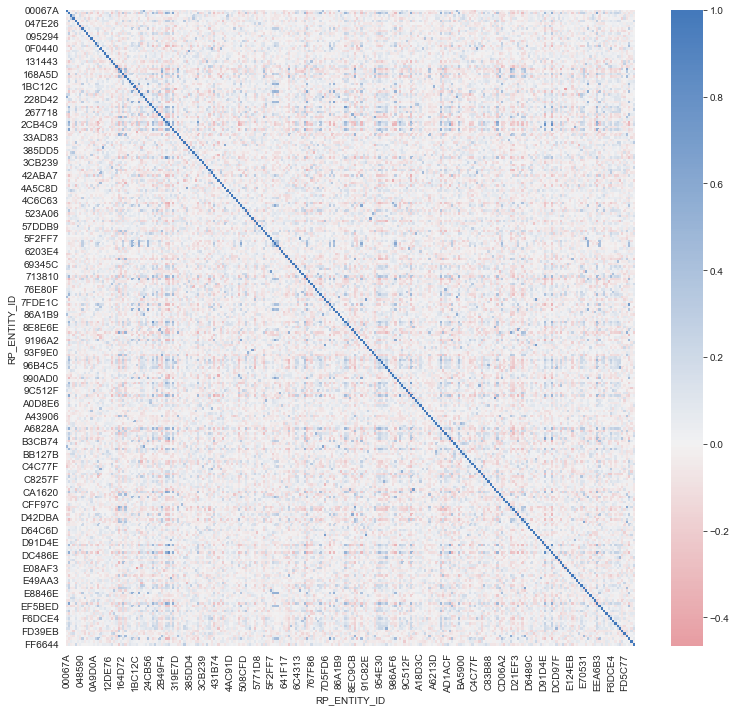

In [97]:
cmap = sns.diverging_palette(10, 250, as_cmap=True)
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(corr, center = 0, cmap = cmap, ax=ax)
fig.tight_layout()


## Cluster Return Series

In [107]:
def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [108]:
# squareform(distance_matrix)
# distance_matrix.loc['1E1C4E','1E1C4E']#

In [118]:
distance_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(distance_matrix), 'average')
# linkage_matrix = linkage(distance_matrix, 'single')

In [119]:
sorted_idx = quasi_diagonalize(linkage_matrix)

### Plot Cluster Map

The linkage_matrix  can be used as input to the seaborn.clustermap function to visualize the resulting hierarchical clustering. The dendrogram displayed by seaborn shows how individual assets and clusters of assets merged based on their relative distances.

Compared to a seaborn.heatmap of the original correlation matrix above, there is now significantly more structure in the sorted data.

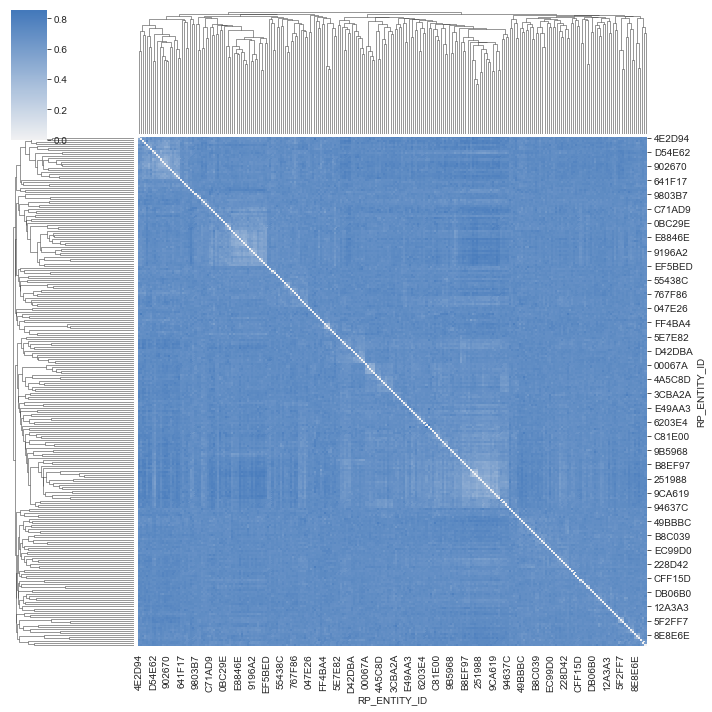

In [120]:
clustergrid = sns.clustermap(distance_matrix, 
                             method='average', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap, center=0);

In [121]:
sorted_idx = clustergrid.dendrogram_row.reordered_ind

In [122]:
sorted_tickers = corr.index[sorted_idx].tolist()

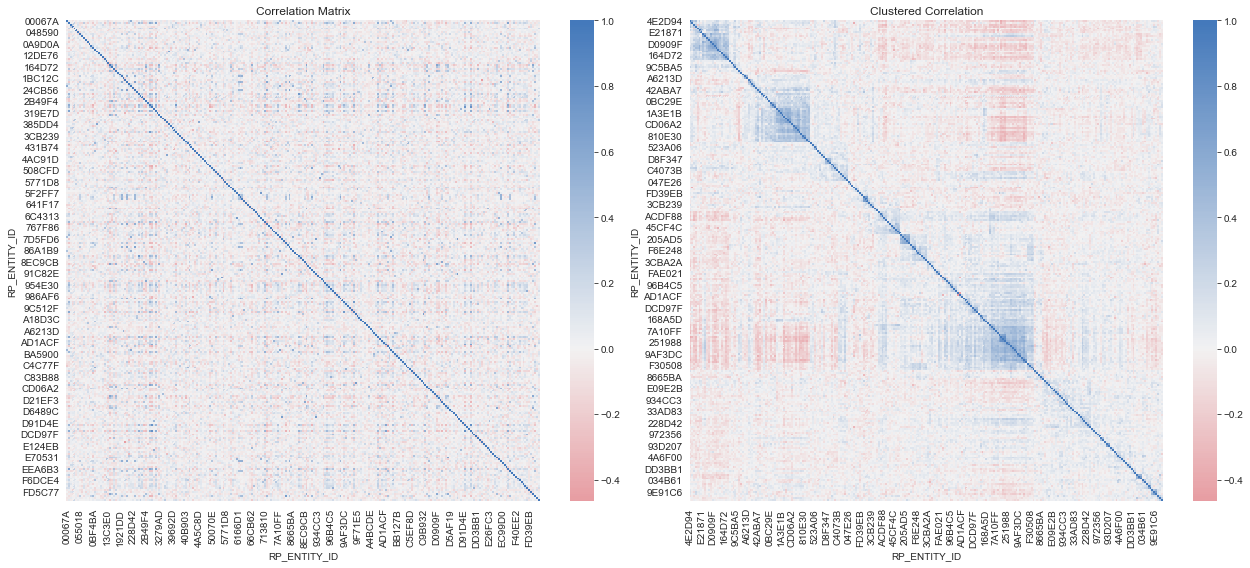

In [123]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(10, 250, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

In [124]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [125]:
# clustergrid = sns.clustermap(distance_matrix, 
#                              method='single', 
#                              row_linkage=linkage_matrix, 
#                              col_linkage=linkage_matrix, 
#                              cmap=cmap, center=0);

In [126]:
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(distance_matrix)


<ipython-input-127-981a6b3e5043>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method)


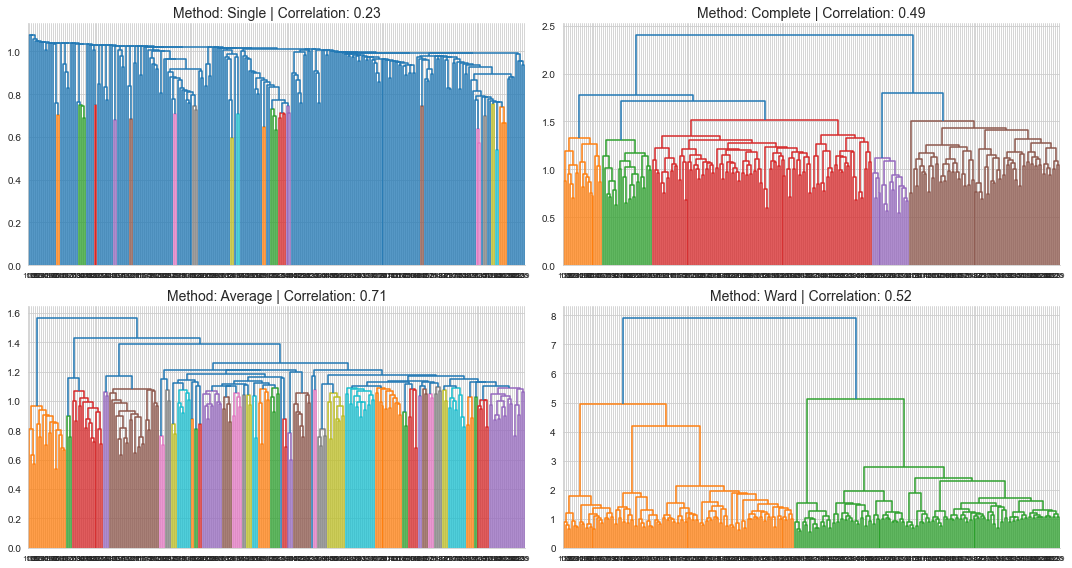

In [127]:
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(distance_matrix, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z,
#                labels=data.label.values,
               orientation='top',
               leaf_rotation=0.,
               leaf_font_size=8.,
               ax=axes[i])
    axes[i].set_title(f'Method: {method.capitalize()} | Correlation: {c:.2f}',
                      fontsize=14)


sns.despine()
fig.tight_layout()

In [148]:
from sklearn.cluster import AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters=3)
clusters = clusterer.fit_predict(distance_matrix)

C:\Users\Reyna\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [149]:
cluster_dict = {}
for asset, label in zip(distance_matrix.columns, clusters):
    cluster_dict[asset] = label
# cluster_dict #Remplacer par le R2 ?

In [150]:
%store cluster_dict

Stored 'cluster_dict' (dict)


In [151]:
clust_df = pd.DataFrame(cluster_dict.items(), columns=['asset','cluster'])

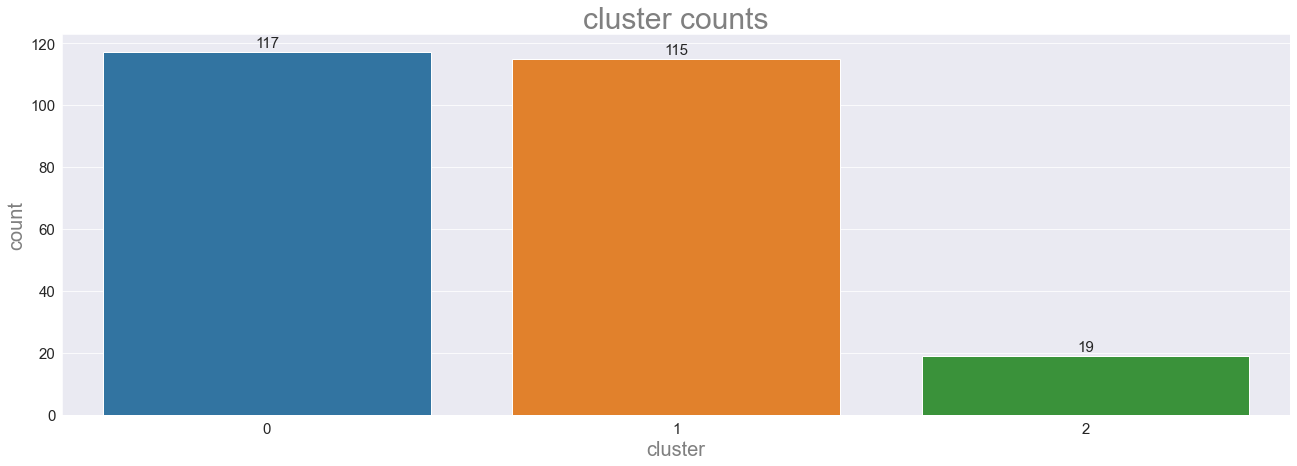

In [152]:
df_hist = clust_df.reset_index().groupby('cluster').count().rename(columns={'index':'count'})

fig = plt.figure(1, figsize=(22, 7))
sns.set_style('darkgrid', {'legend.frameon':True})
b = sns.barplot(x = df_hist.reset_index().iloc[:,0], y = df_hist.reset_index().iloc[:,1])

for p in b.patches:
    b.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
b.axes.set_title("cluster counts",fontsize=30, color='grey')
b.set_xlabel("cluster",fontsize=20, color='grey')
b.set_ylabel("count",fontsize=20, color='grey')
b.tick_params(labelsize=15)

In [31]:
df0['cluster'] = df0['RP_ENTITY_ID'].map(cluster_dict)
df0 = df0.dropna(subset=['cluster'])
df0['cluster'] = df0['cluster'].astype('int64')

In [32]:
df0

RP_ENTITY_ID       DATE  GLOBAL_ALL  GLOBAL_HEAD  GLOBAL_BODY  \
0            00067A 2005-01-05       0.000        0.000        0.000   
1            00067A 2005-01-06       0.000          nan        0.000   
2            00067A 2005-01-20       0.000          nan        0.000   
3            00067A 2005-01-21       0.001        0.010        0.000   
4            00067A 2005-01-26       0.000          nan        0.000   
...             ...        ...         ...          ...          ...   
712479       FF6644 2017-02-09       0.400        0.643        0.327   
712480       FF6644 2017-02-10       0.323        0.180        0.352   
712481       FF6644 2017-02-13       0.352        0.180        0.410   
712482       FF6644 2017-02-15       0.305          nan        0.305   
712483       FF6644 2017-02-16       0.000          nan        0.000   

        GLOBAL_ALL_SG90  GLOBAL_HEAD_SG90  GLOBAL_BODY_SG90  GLOBAL_ALL_SG365  \
0                 0.000             0.000             0.000             0.000   
1                 0.000               nan             0.000             0.000   
2                 0.000               nan             0.000             0.000   
3                 0.001             0.010             0.000             0.001   
4                 0.000               nan             0.000             0.000   
...                 ...               ...               ...               ...   
712479            0.312             0.640             0.203             0.305   
712480            0.407               nan             0.407             0.407   
712481            0.305               nan             0.305             0.305   
712482            0.610               nan             0.610             0.610   
712483              nan               nan               nan               nan   

        GLOBAL_HEAD_SG365  GLOBAL_BODY_SG365  GROUP_A_ALL  GROUP_A_HEAD  \
0                   0.000              0.000          nan           nan   
1                     nan              0.000          nan           nan   
2                     nan              0.000          nan           nan   
3                   0.010              0.000        0.010         0.010   
4                     nan              0.000          nan           nan   
...                   ...                ...          ...           ...   
712479                nan              0.305          nan           nan   
712480                nan              0.407        0.540           nan   
712481                nan              0.305          nan           nan   
712482                nan              0.610          nan           nan   
712483                nan                nan          nan           nan   

        GROUP_A_BODY  GROUP_A_ALL_SG90  GROUP_A_HEAD_SG90  GROUP_A_BODY_SG90  \
0              0.000               nan                nan                nan   
1              0.000               nan                nan                nan   
2              0.000               nan                nan                nan   
3              0.000             0.010              0.010                nan   
4              0.000               nan                nan                nan   
...              ...               ...                ...                ...   
712479         0.327               nan                nan                nan   
712480         0.352               nan                nan                nan   
712481         0.410               nan                nan                nan   
712482         0.305               nan                nan                nan   
712483         0.000               nan                nan                nan   

        GROUP_A_ALL_SG365  GROUP_A_HEAD_SG365  GROUP_A_BODY_SG365  \
0                     nan                 nan                 nan   
1                     nan                 nan                 nan   
2                     nan                 nan                 nan   
3                   0.010      

In [33]:
daily_returns

RP_ENTITY_ID  00067A  013528  0157B1  034B61  03B8CF  047E26  048590  055018  \
DATE                                                                           
2010-01-04       nan     nan  -0.021   0.009     nan   0.048   0.001     nan   
2010-01-05       nan     nan   0.000     nan     nan   0.052     nan   0.033   
2010-01-06       nan  -0.015  -0.023  -0.038   0.009     nan     nan   0.001   
2010-01-07     0.040  -0.012     nan     nan  -0.005  -0.036  -0.030     nan   
2010-01-08       nan  -0.007     nan  -0.004     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.003   0.001   0.008     nan   0.008  -0.017  -0.036   0.004   
2017-02-14    -0.007   0.000  -0.004  -0.009  -0.000   0.022  -0.019   0.010   
2017-02-15    -0.008  -0.007   0.002   0.002   0.002   0.000   0.006   0.003   
2017-02-16     0.019   0.015   0.004     nan     nan  -0.011   0.000  -0.003   
2017-02-17    -0.022     nan  -0.001     nan     nan     nan  -0.003   0.013   

RP_ENTITY_ID  061366  061856  095294  09DE1F  0A9D0A  0BC29E  0BF4BA  0F0440  \
DATE                                                                           
2010-01-04       nan     nan     nan     nan     nan     nan  -0.023     nan   
2010-01-05       nan     nan     nan     nan     nan  -0.025  -0.000     nan   
2010-01-06       nan     nan     nan     nan     nan  -0.011  -0.026   0.008   
2010-01-07       nan     nan  -0.016     nan     nan  -0.026  -0.003  -0.029   
2010-01-08       nan     nan     nan     nan     nan   0.022  -0.010  -0.016   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.011   0.008  -0.009   0.002   0.006   0.005     nan     nan   
2017-02-14     0.014  -0.005  -0.007  -0.010   0.021   0.008     nan   0.028   
2017-02-15       nan  -0.003  -0.004     nan   0.028  -0.100     nan  -0.000   
2017-02-16    -0.016   0.004   0.011   0.013  -0.019   0.025     nan  -0.029   
2017-02-17       nan  -0.003     nan   0.009     nan   0.002     nan     nan   

RP_ENTITY_ID  0F7B72  12A3A3  12DE76  12E454  131443  13C3E0  143C52  14BA06  \
DATE                                                                           
2010-01-04    -0.014     nan     nan     nan     nan     nan     nan     nan   
2010-01-05    -0.029   0.004  -0.010     nan   0.018     nan     nan     nan   
2010-01-06     0.003  -0.002  -0.011     nan     nan     nan     nan  -0.008   
2010-01-07     0.019     nan  -0.002     nan     nan   0.011     nan     nan   
2010-01-08       nan  -0.002   0.001     nan   0.048  -0.021     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13       nan   0.000   0.011  -0.004   0.012     nan     nan  -0.007   
2017-02-14       nan  -0.003   0.007  -0.005  -0.009  -0.021   0.023   0.012   
2017-02-15       nan   0.001   0.010  -0.008  -0.005   0.015     nan  -0.043   
2017-02-16       nan   0.004   0.025   0.005   0.004  -0.010  -0.007  -0.001   
2017-02-17       nan     nan   0.002  -0.004     nan     nan     nan     nan   

RP_ENTITY_ID  164D72  168A5D  16B183  17EDA5  1921DD  1A3E1B  1BC12C  1D1B07  \
DATE                                                                           
2010-01-04       nan     nan     nan   0.007   0.005   0.001     nan     nan   
2010-01-05    -0.003     nan     nan  -0.006  -0.000   0.009     nan     nan   
2010-01-06       nan     nan     nan  -0.008  -0.010   0.016     nan   0.008   
2010-01-07       nan     nan     nan  -0.016   0.045   0.034     nan  -0.016   
2010-01-08       nan     nan     nan   0.007   0.017     nan     nan  -0.024   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13    -0.001   0.008     nan   0.010   0.007   0.004   0.007  -0.003   
2017-02-14     0.004   0.003  -0.033   0.000   0.005   0.015   0.044     nan   
2017-02-15    -0.014  -0.003  -0.004  -0.002  -0.003   0.003  -0.010  -0.003 

# Additional features

### Compute the Relative Strength Index

In [34]:
daily_returns

RP_ENTITY_ID  00067A  013528  0157B1  034B61  03B8CF  047E26  048590  055018  \
DATE                                                                           
2010-01-04       nan     nan  -0.021   0.009     nan   0.048   0.001     nan   
2010-01-05       nan     nan   0.000     nan     nan   0.052     nan   0.033   
2010-01-06       nan  -0.015  -0.023  -0.038   0.009     nan     nan   0.001   
2010-01-07     0.040  -0.012     nan     nan  -0.005  -0.036  -0.030     nan   
2010-01-08       nan  -0.007     nan  -0.004     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.003   0.001   0.008     nan   0.008  -0.017  -0.036   0.004   
2017-02-14    -0.007   0.000  -0.004  -0.009  -0.000   0.022  -0.019   0.010   
2017-02-15    -0.008  -0.007   0.002   0.002   0.002   0.000   0.006   0.003   
2017-02-16     0.019   0.015   0.004     nan     nan  -0.011   0.000  -0.003   
2017-02-17    -0.022     nan  -0.001     nan     nan     nan  -0.003   0.013   

RP_ENTITY_ID  061366  061856  095294  09DE1F  0A9D0A  0BC29E  0BF4BA  0F0440  \
DATE                                                                           
2010-01-04       nan     nan     nan     nan     nan     nan  -0.023     nan   
2010-01-05       nan     nan     nan     nan     nan  -0.025  -0.000     nan   
2010-01-06       nan     nan     nan     nan     nan  -0.011  -0.026   0.008   
2010-01-07       nan     nan  -0.016     nan     nan  -0.026  -0.003  -0.029   
2010-01-08       nan     nan     nan     nan     nan   0.022  -0.010  -0.016   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.011   0.008  -0.009   0.002   0.006   0.005     nan     nan   
2017-02-14     0.014  -0.005  -0.007  -0.010   0.021   0.008     nan   0.028   
2017-02-15       nan  -0.003  -0.004     nan   0.028  -0.100     nan  -0.000   
2017-02-16    -0.016   0.004   0.011   0.013  -0.019   0.025     nan  -0.029   
2017-02-17       nan  -0.003     nan   0.009     nan   0.002     nan     nan   

RP_ENTITY_ID  0F7B72  12A3A3  12DE76  12E454  131443  13C3E0  143C52  14BA06  \
DATE                                                                           
2010-01-04    -0.014     nan     nan     nan     nan     nan     nan     nan   
2010-01-05    -0.029   0.004  -0.010     nan   0.018     nan     nan     nan   
2010-01-06     0.003  -0.002  -0.011     nan     nan     nan     nan  -0.008   
2010-01-07     0.019     nan  -0.002     nan     nan   0.011     nan     nan   
2010-01-08       nan  -0.002   0.001     nan   0.048  -0.021     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13       nan   0.000   0.011  -0.004   0.012     nan     nan  -0.007   
2017-02-14       nan  -0.003   0.007  -0.005  -0.009  -0.021   0.023   0.012   
2017-02-15       nan   0.001   0.010  -0.008  -0.005   0.015     nan  -0.043   
2017-02-16       nan   0.004   0.025   0.005   0.004  -0.010  -0.007  -0.001   
2017-02-17       nan     nan   0.002  -0.004     nan     nan     nan     nan   

RP_ENTITY_ID  164D72  168A5D  16B183  17EDA5  1921DD  1A3E1B  1BC12C  1D1B07  \
DATE                                                                           
2010-01-04       nan     nan     nan   0.007   0.005   0.001     nan     nan   
2010-01-05    -0.003     nan     nan  -0.006  -0.000   0.009     nan     nan   
2010-01-06       nan     nan     nan  -0.008  -0.010   0.016     nan   0.008   
2010-01-07       nan     nan     nan  -0.016   0.045   0.034     nan  -0.016   
2010-01-08       nan     nan     nan   0.007   0.017     nan     nan  -0.024   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13    -0.001   0.008     nan   0.010   0.007   0.004   0.007  -0.003   
2017-02-14     0.004   0.003  -0.033   0.000   0.005   0.015   0.044     nan   
2017-02-15    -0.014  -0.003  -0.004  -0.002  -0.003   0.003  -0.010  -0.003 

In [35]:
prices = daily_returns.copy()
prices =  np.exp(prices).cumprod()*100
# price.pivot_table(index='DATE', columns='RP_ENTITY_ID')
# price.iloc[0,:]=100
prices = pd.DataFrame(prices.unstack(0))
prices.rename(columns={0: 'close'}, inplace=True)
prices

close
RP_ENTITY_ID DATE              
00067A       2010-01-04     nan
             2010-01-05     nan
             2010-01-06     nan
             2010-01-07 104.051
             2010-01-08     nan
...                         ...
FF6644       2017-02-13 162.818
             2017-02-14     nan
             2017-02-15 162.831
             2017-02-16 163.003
             2017-02-17     nan

[467200 rows x 1 columns]

In [36]:
# df1 = df0.set_index(['RP_ENTITY_ID','DATE'])
add_features = pd.DataFrame()
add_features['rsi'] = prices.dropna().groupby(level='RP_ENTITY_ID').close.apply(RSI)/100-0.5
add_features

rsi
RP_ENTITY_ID DATE            
00067A       2010-01-07   nan
             2010-01-28   nan
             2010-02-01   nan
             2010-02-02   nan
             2010-02-03   nan
...                       ...
FF6644       2017-02-09 0.067
             2017-02-10 0.101
             2017-02-13 0.172
             2017-02-15 0.173
             2017-02-16 0.179

[230998 rows x 1 columns]

C:\Users\Reyna\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


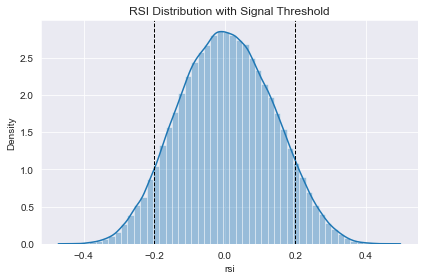

In [37]:
ax = sns.distplot(add_features['rsi'])
ax.axvline(30/100-0.5, ls='--', lw=1, c='k')
ax.axvline(70/100-0.5, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [38]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [39]:
prices = (prices.join(prices.dropna()
                      .groupby(level='RP_ENTITY_ID')
                      .close
                      .apply(compute_bb)))

In [40]:
add_features['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
add_features['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
prices.drop(['bb_high', 'bb_low'], axis=1, inplace=True)

C:\Users\Reyna\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Reyna\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


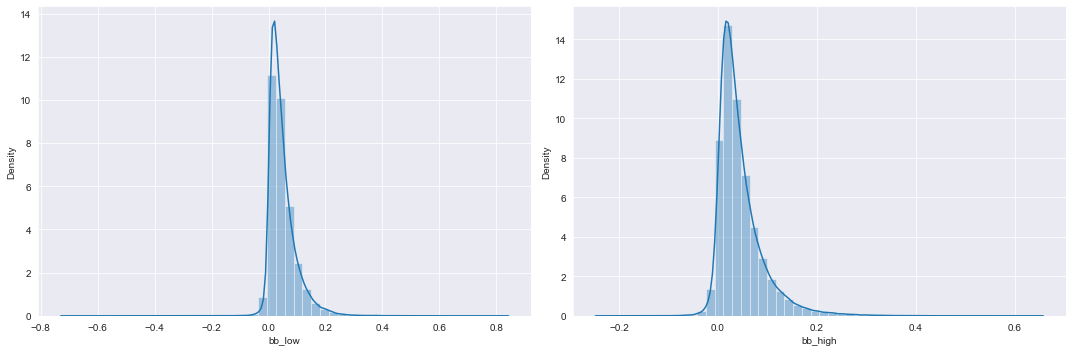

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(add_features.loc[:, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(add_features.loc[:, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Moving Average Convergence/Divergence

In [42]:
prices

close
RP_ENTITY_ID DATE              
00067A       2010-01-04     nan
             2010-01-05     nan
             2010-01-06     nan
             2010-01-07 104.051
             2010-01-08     nan
...                         ...
FF6644       2017-02-13 162.818
             2017-02-14     nan
             2017-02-15 162.831
             2017-02-16 163.003
             2017-02-17     nan

[467200 rows x 1 columns]

In [43]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [44]:
add_features['macd'] = (prices.dropna()
                  .groupby('RP_ENTITY_ID', group_keys=False)
                  .close
                  .apply(compute_macd))

In [45]:
add_features.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    222,715.0
mean          -0.0
std            1.0
min           -5.5
0.1%          -3.6
1%            -2.5
2%            -2.1
3%            -1.9
4%            -1.8
5%            -1.6
50%            0.0
95%            1.6
96%            1.7
97%            1.9
98%            2.1
99%            2.4
99.9%          3.5
max            5.3
Name: macd, dtype: object

C:\Users\Reyna\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


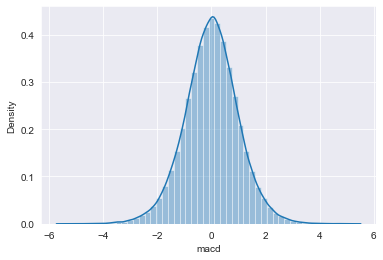

In [46]:
sns.distplot(add_features.macd.dropna());

## Compute Lagged Returns

In [47]:
lags = [1, 3, 5, 10, 21]

In [48]:
returns = prices.groupby(level='RP_ENTITY_ID').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

In [49]:
q = 0.0001

In [50]:
prices

close
RP_ENTITY_ID DATE              
00067A       2010-01-04     nan
             2010-01-05     nan
             2010-01-06     nan
             2010-01-07 104.051
             2010-01-08     nan
...                         ...
FF6644       2017-02-13 162.818
             2017-02-14     nan
             2017-02-15 162.831
             2017-02-16 163.003
             2017-02-17     nan

[467200 rows x 1 columns]

### Winsorize outliers

In [51]:
for lag in lags:
    add_features[f'return_{lag}d'] = (prices.groupby(level='RP_ENTITY_ID').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns

In [52]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        add_features[f'return_{lag}d_lag{t}'] = (add_features.groupby(level='RP_ENTITY_ID')
                                           [f'return_{lag}d'].shift(t * lag))

### Volatility 12-24d

In [53]:
vol_12d = 

SyntaxError: invalid syntax (<ipython-input-53-38776fa5ada2>, line 1)

In [ ]:
prices

## Compute Forward Returns

In [ ]:
# for t in [1, 5, 10, 21]:
#     add_features[f'target_{t}d'] = add_features.groupby(level='RP_ENTITY_ID')[f'return_{t}d'].shift(-t)

## Create time and sector dummy variables

In [ ]:
# add_features['year'] = add_features.index.get_level_values('DATE').year
# add_features['month'] = add_features.index.get_level_values('DATE').month

In [ ]:
add_features.info(null_counts=True)

In [ ]:
%store add_features

In [69]:
df = pd.read_csv('../SampleDataSet.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
###col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
###delete these cols
df = df.loc[:, ~df.columns.isin(cols_to_drop)]


nb_date_ceil = 15000
nb_date_floor = 110 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

df = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]

df['T0_RETURN_log'] = np.log(1+df.loc[:,'T0_RETURN'].copy()) ##use log return
df['T1_RETURN_log'] = np.log(1+df.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df0 = df.loc[:, ~df.columns.isin(cols_to_drop)].copy()

In [70]:
daily_returns = df0.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
# daily_returns = daily_returns.resample('D').sum().dropna(how='all')
daily_returns = daily_returns.loc[daily_returns.index.year >= 2004,:]
daily_returns = daily_returns.dropna(how='all')
daily_returns

RP_ENTITY_ID  00067A  003B70  006885  009397  013528  0157B1  018C11  0246B2  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan   0.018     nan     nan   
2005-01-04       nan     nan     nan     nan     nan  -0.038     nan     nan   
2005-01-05     0.029     nan     nan     nan     nan   0.001     nan     nan   
2005-01-06    -0.006     nan     nan     nan     nan     nan  -0.004     nan   
2005-01-07       nan     nan     nan     nan     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13     0.003   0.002     nan     nan   0.001   0.008     nan  -0.024   
2017-02-14    -0.007  -0.017     nan  -0.006   0.000  -0.004     nan   0.008   
2017-02-15    -0.008  -0.013     nan  -0.004  -0.007   0.002     nan     nan   
2017-02-16     0.019   0.006     nan     nan   0.015   0.004     nan  -0.003   
2017-02-17    -0.022     nan     nan   0.002     nan  -0.001     nan     nan   

RP_ENTITY_ID  02631C  031B03  034B61  03596A  03B8CF  03CF95  03FAA6  047E26  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-04       nan     nan     nan     nan     nan     nan     nan  -0.016   
2005-01-05       nan     nan     nan     nan     nan     nan     nan   0.014   
2005-01-06       nan     nan     nan     nan     nan     nan     nan   0.011   
2005-01-07       nan     nan     nan     nan     nan     nan     nan  -0.006   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13       nan     nan     nan     nan   0.008   0.011   0.013  -0.017   
2017-02-14       nan     nan  -0.009   0.008  -0.000   0.008   0.027   0.022   
2017-02-15       nan     nan   0.002   0.008   0.002   0.001  -0.007   0.000   
2017-02-16       nan     nan     nan  -0.010     nan   0.009   0.001  -0.011   
2017-02-17       nan     nan     nan     nan     nan     nan  -0.004     nan   

RP_ENTITY_ID  048590  055018  055551  0555FF  061366  061856  0624BE  063384  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-04       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-05       nan  -0.001     nan     nan     nan     nan     nan     nan   
2005-01-06       nan     nan     nan     nan     nan     nan   0.051     nan   
2005-01-07       nan     nan  -0.001     nan     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13    -0.036   0.004     nan     nan   0.011   0.008     nan     nan   
2017-02-14    -0.019   0.010     nan     nan   0.014  -0.005     nan   0.000   
2017-02-15     0.006   0.003     nan     nan     nan  -0.003     nan   0.091   
2017-02-16     0.000  -0.003   0.139     nan  -0.016   0.004     nan   0.005   
2017-02-17    -0.003   0.013   0.026   0.009     nan  -0.003     nan     nan   

RP_ENTITY_ID  0665EF  067779  067883  06E74C  06EF42  06F889  070B45  072FC5  \
DATE                                                                           
2005-01-03       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-04       nan     nan     nan     nan     nan     nan     nan  -0.002   
2005-01-05       nan     nan     nan     nan     nan     nan     nan     nan   
2005-01-06    -0.010     nan     nan     nan     nan     nan     nan     nan   
2005-01-07       nan     nan     nan     nan     nan     nan     nan     nan   
...              ...     ...     ...     ...     ...     ...     ...     ...   
2017-02-13       nan     nan     nan     nan     nan     nan   0.000     nan   
2017-02-14       nan  -0.005     nan     nan  -0.014     nan  -0.003     nan   
2017-02-15       nan     nan     nan     nan     nan     nan     nan     nan 

In [71]:
freq = '6BMS' #'BY'
daily_returns_count6M = daily_returns.resample(freq).count()

In [72]:
daily_returns_count6M 

RP_ENTITY_ID  00067A  003B70  006885  009397  013528  0157B1  018C11  0246B2  \
DATE                                                                           
2005-01-03        36       0       0       0      28      24      13       0   
2005-07-01        35       9       0       0      46      20      15       0   
2006-01-02        33       6       0       0      32      30      17       0   
2006-07-03        43       0       0       0      54      26      20       0   
2007-01-01        39       0       0       0      55      50      19       0   
2007-07-02        58       0       0       0      70      56      17       0   
2008-01-01        60       0       0       0      59      64      21       0   
2008-07-01        54       0       0       0      51      65       0       0   
2009-01-01        46       0       0       0      69      82       0       0   
2009-07-01        46      11       6       0      77      68       0       0   
2010-01-01        42      11       7       0      74      77       0       0   
2010-07-01        56      10       8       3      49      79       0       0   
2011-01-03        68       9       7      15      75      99       0       0   
2011-07-01        64      14      10       9      86     116       0      13   
2012-01-02        63      18      14      17      82     116       0      31   
2012-07-02        77      38      11      11      75     119       0      28   
2013-01-01        58      51      18      12      83     112       0      27   
2013-07-01        61      47      15      23      74     118       0      44   
2014-01-01        63      28      23      15      73     121       0      48   
2014-07-01        56      20      29      16      81     123       0      49   
2015-01-01        78      34       0       9      67     118       0      34   
2015-07-01       109      24       0      17      76     125       0      28   
2016-01-01        93      29       0      33      67     124       0      42   
2016-07-01       106      63       0      43      87     127       0      51   
2017-01-02        29      19       0      10      26      32       0      16   

RP_ENTITY_ID  02631C  031B03  034B61  03596A  03B8CF  03CF95  03FAA6  047E26  \
DATE                                                                           
2005-01-03         0       0       0       0      22       0       0      67   
2005-07-01         0       0       0       0      20       0       0      73   
2006-01-02         0       0       0       0      20       0       0      51   
2006-07-03         0       0       0       0      35       0       0      67   
2007-01-01         0       0       0       0      47       0       0      71   
2007-07-02         0       0       0       0      45       0       0      58   
2008-01-01         0       0       0       0      33       0       0      65   
2008-07-01         0       0      19      17      49       0       0      76   
2009-01-01         0       0      25      13      31       0       1      61   
2009-07-01         0       0      21      12      27       0      25      76   
2010-01-01         0       0      47       7      41       0      35      67   
2010-07-01         0      24      33      19      56       0      43      70   
2011-01-03         0      23      38      16      48       0      27      95   
2011-07-01         0      21      41      14      55       0      28      96   
2012-01-02         0      22      50      10      48       0      40      99   
2012-07-02         0      32      63      20      65       0      40     108   
2013-01-01         0      46      71      24      49       0      44     124   
2013-07-01         0      40      61      21      50       0      25     115   
2014-01-01         0       0      57      27      51       0      24     112   
2014-07-01         0       0      77      50      57       0      21     111   
2015-01-01         0       0      73      33      46       0      16      92   

In [73]:
126*0.9

113.4

In [74]:
daily_returns_count6M>=113

RP_ENTITY_ID  00067A  003B70  006885  009397  013528  0157B1  018C11  0246B2  \
DATE                                                                           
2005-01-03     False   False   False   False   False   False   False   False   
2005-07-01     False   False   False   False   False   False   False   False   
2006-01-02     False   False   False   False   False   False   False   False   
2006-07-03     False   False   False   False   False   False   False   False   
2007-01-01     False   False   False   False   False   False   False   False   
2007-07-02     False   False   False   False   False   False   False   False   
2008-01-01     False   False   False   False   False   False   False   False   
2008-07-01     False   False   False   False   False   False   False   False   
2009-01-01     False   False   False   False   False   False   False   False   
2009-07-01     False   False   False   False   False   False   False   False   
2010-01-01     False   False   False   False   False   False   False   False   
2010-07-01     False   False   False   False   False   False   False   False   
2011-01-03     False   False   False   False   False   False   False   False   
2011-07-01     False   False   False   False   False    True   False   False   
2012-01-02     False   False   False   False   False    True   False   False   
2012-07-02     False   False   False   False   False    True   False   False   
2013-01-01     False   False   False   False   False   False   False   False   
2013-07-01     False   False   False   False   False    True   False   False   
2014-01-01     False   False   False   False   False    True   False   False   
2014-07-01     False   False   False   False   False    True   False   False   
2015-01-01     False   False   False   False   False    True   False   False   
2015-07-01     False   False   False   False   False    True   False   False   
2016-01-01     False   False   False   False   False    True   False   False   
2016-07-01     False   False   False   False   False    True   False   False   
2017-01-02     False   False   False   False   False   False   False   False   

RP_ENTITY_ID  02631C  031B03  034B61  03596A  03B8CF  03CF95  03FAA6  047E26  \
DATE                                                                           
2005-01-03     False   False   False   False   False   False   False   False   
2005-07-01     False   False   False   False   False   False   False   False   
2006-01-02     False   False   False   False   False   False   False   False   
2006-07-03     False   False   False   False   False   False   False   False   
2007-01-01     False   False   False   False   False   False   False   False   
2007-07-02     False   False   False   False   False   False   False   False   
2008-01-01     False   False   False   False   False   False   False   False   
2008-07-01     False   False   False   False   False   False   False   False   
2009-01-01     False   False   False   False   False   False   False   False   
2009-07-01     False   False   False   False   False   False   False   False   
2010-01-01     False   False   False   False   False   False   False   False   
2010-07-01     False   False   False   False   False   False   False   False   
2011-01-03     False   False   False   False   False   False   False   False   
2011-07-01     False   False   False   False   False   False   False   False   
2012-01-02     False   False   False   False   False   False   False   False   
2012-07-02     False   False   False   False   False   False   False   False   
2013-01-01     False   False   False   False   False   False   False    True   
2013-07-01     False   False   False   False   False   False   False    True   
2014-01-01     False   False   False   False   False   False   False   False   
2014-07-01     False   False   False   False   False   False   False   False   
2015-01-01     False   False   False   False   False   False   False   False   

In [75]:
(daily_returns_count6M>=110).sum(axis=1)

DATE
2005-01-03     7
2005-07-01     7
2006-01-02     6
2006-07-03     9
2007-01-01    18
2007-07-02    16
2008-01-01    18
2008-07-01    15
2009-01-01    14
2009-07-01    19
2010-01-01    19
2010-07-01    19
2011-01-03    26
2011-07-01    36
2012-01-02    35
2012-07-02    32
2013-01-01    34
2013-07-01    29
2014-01-01    31
2014-07-01    40
2015-01-01    32
2015-07-01    37
2016-01-01    39
2016-07-01    47
2017-01-02     0
Freq: 6BMS, dtype: int64

In [76]:
(daily_returns_count6M>=114).sum(axis=1).sum()

483

In [77]:
# daily_returns_count6M.loc[(daily_returns_count6M>=110)==True,:]

In [78]:
daily_returns_count6M_selec = daily_returns_count6M>=110

# (daily_returns_count6M>=113).dropna(how='all')
daily_returns_count6M_selec

RP_ENTITY_ID  00067A  003B70  006885  009397  013528  0157B1  018C11  0246B2  \
DATE                                                                           
2005-01-03     False   False   False   False   False   False   False   False   
2005-07-01     False   False   False   False   False   False   False   False   
2006-01-02     False   False   False   False   False   False   False   False   
2006-07-03     False   False   False   False   False   False   False   False   
2007-01-01     False   False   False   False   False   False   False   False   
2007-07-02     False   False   False   False   False   False   False   False   
2008-01-01     False   False   False   False   False   False   False   False   
2008-07-01     False   False   False   False   False   False   False   False   
2009-01-01     False   False   False   False   False   False   False   False   
2009-07-01     False   False   False   False   False   False   False   False   
2010-01-01     False   False   False   False   False   False   False   False   
2010-07-01     False   False   False   False   False   False   False   False   
2011-01-03     False   False   False   False   False   False   False   False   
2011-07-01     False   False   False   False   False    True   False   False   
2012-01-02     False   False   False   False   False    True   False   False   
2012-07-02     False   False   False   False   False    True   False   False   
2013-01-01     False   False   False   False   False    True   False   False   
2013-07-01     False   False   False   False   False    True   False   False   
2014-01-01     False   False   False   False   False    True   False   False   
2014-07-01     False   False   False   False   False    True   False   False   
2015-01-01     False   False   False   False   False    True   False   False   
2015-07-01     False   False   False   False   False    True   False   False   
2016-01-01     False   False   False   False   False    True   False   False   
2016-07-01     False   False   False   False   False    True   False   False   
2017-01-02     False   False   False   False   False   False   False   False   

RP_ENTITY_ID  02631C  031B03  034B61  03596A  03B8CF  03CF95  03FAA6  047E26  \
DATE                                                                           
2005-01-03     False   False   False   False   False   False   False   False   
2005-07-01     False   False   False   False   False   False   False   False   
2006-01-02     False   False   False   False   False   False   False   False   
2006-07-03     False   False   False   False   False   False   False   False   
2007-01-01     False   False   False   False   False   False   False   False   
2007-07-02     False   False   False   False   False   False   False   False   
2008-01-01     False   False   False   False   False   False   False   False   
2008-07-01     False   False   False   False   False   False   False   False   
2009-01-01     False   False   False   False   False   False   False   False   
2009-07-01     False   False   False   False   False   False   False   False   
2010-01-01     False   False   False   False   False   False   False   False   
2010-07-01     False   False   False   False   False   False   False   False   
2011-01-03     False   False   False   False   False   False   False   False   
2011-07-01     False   False   False   False   False   False   False   False   
2012-01-02     False   False   False   False   False   False   False   False   
2012-07-02     False   False   False   False   False   False   False   False   
2013-01-01     False   False   False   False   False   False   False    True   
2013-07-01     False   False   False   False   False   False   False    True   
2014-01-01     False   False   False   False   False   False   False    True   
2014-07-01     False   False   False   False   False   False   False    True   
2015-01-01     False   False   False   False   False   False   False   False   

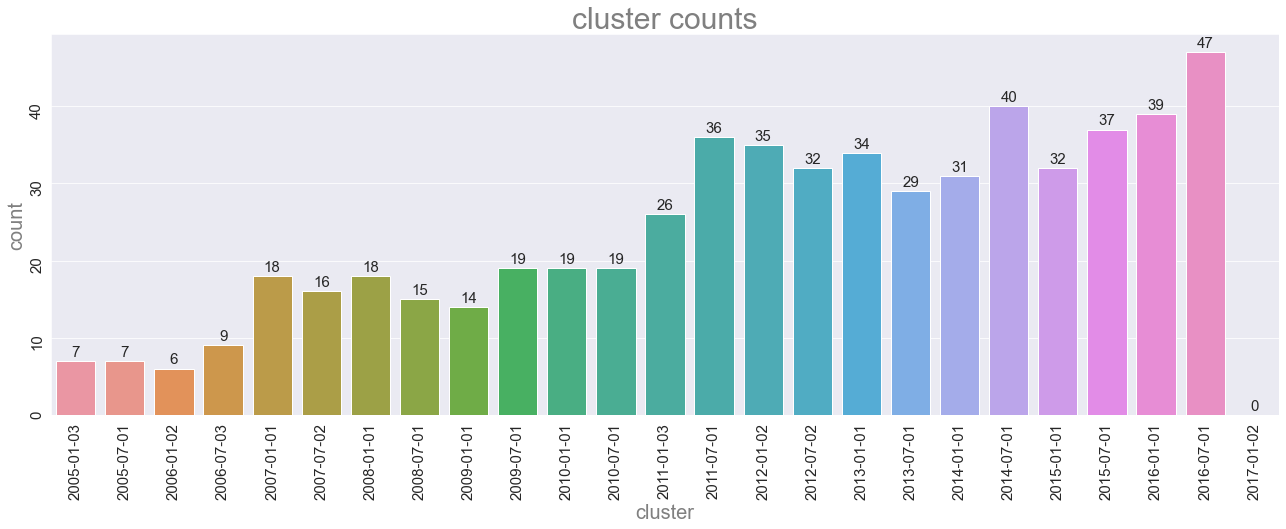

In [79]:
df_hist = (daily_returns_count6M>=110).sum(axis=1)#.reset_index()
df_hist.index=df_hist.index.strftime('%Y-%m-%d')

fig = plt.figure(1, figsize=(22, 7))
sns.set_style('darkgrid', {'legend.frameon':True})
b = sns.barplot(x = df_hist.reset_index().iloc[:,0], y = df_hist.reset_index().iloc[:,1])

for p in b.patches:
    b.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
b.axes.set_title("cluster counts",fontsize=30, color='grey')
b.set_xlabel("cluster",fontsize=20, color='grey')
b.set_ylabel("count",fontsize=20, color='grey')
b.tick_params(labelsize=15, rotation=90)

In [80]:
datasset_per_Semester = list(daily_returns_count6M_selec.replace(False, np.NaN)
                             .dropna(how='all', axis=1))

In [81]:
dataset_inter = {}
for idx in list(daily_returns_count6M_selec.index):
    dataset_inter[idx] = list(daily_returns_count6M_selec.loc[idx].index[daily_returns_count6M_selec.loc[idx].values])

In [82]:
dataset ={k: v for k, v in dataset_inter.items() if k.year >= 2011}

In [84]:
%store dataset

Stored 'dataset' (dict)
